# Ciencia de Datos. TP6: Procesamiento de Lenguaje Natural

Axel Maddonni, LU 200/14 <br>
Federico Patane, LU 683/10<br>


*Diciembre 2017*

***

## Ejercicio 1: Asociación de Palabras

### 1. Lectura del Corpus

Para leer el corpus ap primero modificamos el archivo .txt para poder ser parseado como un .xml. Para eso, agregamos una etiqueta raíz (todo xml debe tener una), con el nombre "CORPUS" al principio y al final del archivo y lo guardamos con el nombre "ap.xml". Luego, utilizamos la librería "minidom" para parsear el xml resultante y extraer los textos de los documentos como pide el enunciado.

In [111]:
# Imports e inicializacion de variables globales para nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import math
from collections import OrderedDict

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import wordnet as wn

sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

In [112]:
# Creacion del xml
file_in = open("ap/ap.txt", "r")
txt = file_in.read()
file_in.close()

xml = "<CORPUS>" + txt + "</CORPUS>"
xml = xml.replace('&','&amp;')

file_out = open("ap/ap.xml", "w")
file_out.write(xml)
file_out.close()

In [114]:
from xml.dom import minidom

# Parseo del xml
xmldoc = minidom.parse('ap/ap.xml')
doclist = xmldoc.getElementsByTagName('DOC')

docs = {}

for doc in doclist:
    docno = doc.getElementsByTagName('DOCNO')[0].firstChild.data.strip()
    text = doc.getElementsByTagName('TEXT')[0].firstChild.data.strip()
    docs[docno] = text

### 2. Procesamiento y Armado del Vocabulario

#### Código para la clasificación de palabras usando tags de WordNet

In [115]:
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']

def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']

def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return None

#### Código para expansión de contracciones de palabras

In [116]:
import re

cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

caseInsCList = {}

for key, value in cList.items():
    caseInsCList[key.lower()] = value

c_re = re.compile('(%s)' % '|'.join(caseInsCList.keys()), re.IGNORECASE)

def expandContractions(text, c_re=c_re):
    def replace(match):
        return caseInsCList[match.group(0).lower()]
    return c_re.sub(replace, text)

#### Pasos para el procesamiento y armado del Vocabulario

1. Separación en sentencias
2. Expansión de contracciones
3. Tokenización
4. Pos-tagging
5. Uso del pos-tagging para lematizar
6. Eliminación de Stop-words y palabras no-alfanuméricas

Para los puntos 1, 3, 4, 5 y 6 utilizamos funciones provistas por nltk, como se puede ver en el siguiente código:

In [117]:
def lemmatize_with_tag(word, tag):
    wordType = penn_to_wn(tag)
    if wordType is None:
        return None
    return wordnet_lemmatizer.lemmatize(word, pos=wordType)

vocabulary = {}
corpus_processed_tokens = []
positions = {}

pos = 0

for docno, text in docs.items():
    # 1
    sents = sent_detector.tokenize(text)
    for sent in sents:
        # 2
        sent = expandContractions(sent)
        # 3
        tokens = tokenizer.tokenize(sent)
        # 4
        token_with_tags = nltk.pos_tag(tokens)
        for token_with_tag in token_with_tags:
            # 5
            word = lemmatize_with_tag(token_with_tag[0], token_with_tag[1])
            # 6
            if word is not None and word not in stopwords.words('english') and word.isalpha():
                corpus_processed_tokens.append(word)
                if word in vocabulary:
                    vocabulary[word] += 1
                    positions[word].append(pos)
                else:
                    vocabulary[word] = 1
                    positions[word] = [pos]
                pos += 1

#### Tamaño del Vocabulario final

In [118]:
print(len(vocabulary))

31356


### 3. Pares más asociados

Primero, mostramos cuáles son las 500 palabras con más apariciones en el vocabulario:

In [119]:
sorted_vocabulary = sorted(vocabulary.items(), key=operator.itemgetter(1))
the500 = list(map(lambda x: x[0], sorted_vocabulary[-500:]))[::-1]

#### Las 500 palabras con más apariciones, de mayor a menor

In [120]:
the500

[u'say',
 u'year',
 u'percent',
 u'people',
 u'also',
 u'government',
 u'make',
 u'official',
 u'report',
 u'last',
 u'go',
 u'take',
 u'state',
 u'time',
 u'Bush',
 u'include',
 u'new',
 u'get',
 u'day',
 u'first',
 u'Soviet',
 u'tell',
 u'week',
 u'New',
 u'United',
 u'company',
 u'use',
 u'call',
 u'work',
 u'month',
 u'country',
 u'give',
 u'come',
 u'today',
 u'plan',
 u'president',
 u'police',
 u'Thursday',
 u'American',
 u'group',
 u'States',
 u'Tuesday',
 u'market',
 u'member',
 u'price',
 u'President',
 u'issue',
 u'Monday',
 u'high',
 u'Friday',
 u'force',
 u'Wednesday',
 u'know',
 u'think',
 u'want',
 u'find',
 u'begin',
 u'charge',
 u'leader',
 u'home',
 u'end',
 u'York',
 u'leave',
 u'show',
 u'hold',
 u'case',
 u'program',
 u'kill',
 u'good',
 u'help',
 u'military',
 u'support',
 u'increase',
 u'nation',
 u'House',
 u'right',
 u'see',
 u'federal',
 u'late',
 u'order',
 u'many',
 u'vote',
 u'talk',
 u'city',
 u'ask',
 u'rate',
 u'expect',
 u'part',
 u'political',
 u'former

Para calcular los pares más asociados primero probamos la herramienta de nltk BigramCollocationFinder, que permite encontrar y rankear colocaciones (palabras que suelen aparecer juntas), utilizando un tamaño de ventana de tamaño 5, como se menciona en el paper correspondiente a este ejercicio.

El resultado nos dejó algo desconcertados ya que no podíamos ver a simple vista una relación muy estrecha entre los pares que obtuvimos, de modo que decidimos implementar "información mutua", con la fórmula como se la explica en el paper para chequear los resultados.

Para este ejercicio, utilizamos los tokens del corpus luego de ser procesado, ya que estamos buscando pares que contengan las 500 palabras con más frecuencia en el vocabulario, que se obtuvieron después del procesamiento del texto.

#### Pares usando BigramCollocationFinder

In [121]:
from nltk.collocations import BigramCollocationFinder
bigram_measures = nltk.collocations.BigramAssocMeasures()

def getBestPairContaining(word, tokens):
    finder = BigramCollocationFinder.from_words(tokens, window_size = 5)
    finder.apply_ngram_filter(lambda w1, w2: word not in (w1, w2))
    return finder.nbest(bigram_measures.pmi, 1)[0]

In [122]:
pairs = []
for word in the500:
    pairs.append(getBestPairContaining(word, corpus_processed_tokens))

for i in range(0, len(the500)):
    print("Rank %d. Word: %s" % (i+1, the500[i]))
    print("Best pair: ", pairs[i])

Rank 1. Word: say
('Best pair: ', (u'Baruch', u'say'))
Rank 2. Word: year
('Best pair: ', (u'Kirov', u'year'))
Rank 3. Word: percent
('Best pair: ', (u'Decreased', u'percent'))
Rank 4. Word: people
('Best pair: ', (u'people', u'shady'))
Rank 5. Word: also
('Best pair: ', (u'Carbonell', u'also'))
Rank 6. Word: government
('Best pair: ', (u'Amazonas', u'government'))
Rank 7. Word: make
('Best pair: ', (u'Account', u'make'))
Rank 8. Word: official
('Best pair: ', (u'Adris', u'official'))
Rank 9. Word: report
('Best pair: ', (u'AIDs', u'report'))
Rank 10. Word: last
('Best pair: ', (u'Agrigento', u'last'))
Rank 11. Word: go
('Best pair: ', (u'go', u'glider'))
Rank 12. Word: take
('Best pair: ', (u'anyplace', u'take'))
Rank 13. Word: state
('Best pair: ', (u'Assam', u'state'))
Rank 14. Word: time
('Best pair: ', (u'elapse', u'time'))
Rank 15. Word: Bush
('Best pair: ', (u'Bush', u'Bonesman'))
Rank 16. Word: include
('Best pair: ', (u'Acceptances', u'include'))
Rank 17. Word: new
('Best pair

#### Pares calculados a mano, siguiendo la explicación del paper

In [144]:
def most_associated_pairs(corpus_processed_tokens, vocabulary, positions, word1, window_size = None):
    if window_size is None:
        window_size = 5

    joint_probability_after = {}
    joint_probability_before = {}

    for p in positions[word1]:
        for i in range(0, window_size):
            
            if p+i+1 < len(corpus_processed_tokens):
                word2 = corpus_processed_tokens[p+i+1]
                if word2 in joint_probability_after:
                    joint_probability_after[word2] += 1
                else:
                    joint_probability_after[word2] = 1

            if p-i-1 >= 0:
                word2 = corpus_processed_tokens[p-i-1]
                if word2 in joint_probability_before:
                    joint_probability_before[word2] += 1
                else:
                    joint_probability_before[word2] = 1

    max_mutual_info = 0
    max_mutual_info_words = []

    N = len(corpus_processed_tokens)
    
    for word2 in joint_probability_after:
        mutual_info = np.log2( (joint_probability_after[word2] / float(N)) /
                              ( float(vocabulary[word1] / float(N)) * float(vocabulary[word2] / float(N)) ) )
        if mutual_info > max_mutual_info:
            max_mutual_info = mutual_info
            max_mutual_info_words = [word2]
        elif mutual_info == max_mutual_info:
            max_mutual_info_words.append(word2)
    
    for word2 in joint_probability_before:
        mutual_info = np.log2( (joint_probability_before[word2] / float(N)) /
                              ( float(vocabulary[word1] / float(N)) * float(vocabulary[word2] / float(N)) ) )
        if mutual_info > max_mutual_info:
            max_mutual_info = mutual_info
            max_mutual_info_words = [word2]
        elif mutual_info == max_mutual_info:
            max_mutual_info_words.append(word2)

    return max_mutual_info, max_mutual_info_words

In [148]:
rank = 1

real_associations = []

for word in the500:
    max_mutual_info, most_associated_words = most_associated_pairs(corpus_processed_tokens, vocabulary, positions, word, window_size=5)
    print("Rank %d. Word: %s" % (rank, word))
    print("Máximo valor de información mutua: %d" % max_mutual_info)
    print("Palabras más asociadas: " + str(', '.join(most_associated_words)))
    print("----------------------------")
    
    if len(most_associated_words) == 1:
        real_associations.append((max_mutual_info, word, most_associated_words[0]))

    rank += 1

Rank 1. Word: say
Máximo valor de información mutua: 6
Palabras más asociadas: diminishing, almighty, Vassiliou, Brazilians, Espero, debriefing, Chianelli, Shimoyama, Bakir, hello, Celebrities, Uniformed, Kjell, deacon, writeoff, Quillen, senatorial, Logar, parry, Josephine, immobile, underfunded, predate, overcarried, informative, shorn, gleefully, Counseling, Philo, squealer, Cheltenham, Jackle, entrust, Participation, Ms, bravery, believeable, severest, MacMillin, mugging, tracer, winegrapes, doer, Fairield, Boraski, compromiser, frisky, hidebound, Studio, McCort, sump, domed, Scared, enlightened, Butts, poached, interplay, Raven, muzzleloader, vibrancy, Baruch, abrogate, observing, prepayment, Hawkes, candlewax, Grigg, squeak
----------------------------
Rank 2. Word: year
Máximo valor de información mutua: 8
Palabras más asociadas: vigor, LEV, Renault, Ironically, countersuit, Saab, Marks, Lemons, Counting, pentalties, Kirov
----------------------------
Rank 3. Word: percent
Máxim

Máximo valor de información mutua: 9
Palabras más asociadas: glider, Estes
----------------------------
Rank 12. Word: take
Máximo valor de información mutua: 9
Palabras más asociadas: lick, anyplace
----------------------------
Rank 13. Word: state
Máximo valor de información mutua: 9
Palabras más asociadas: Brautigan, mantis, Lately, Assam, owes
----------------------------
Rank 14. Word: time
Máximo valor de información mutua: 9
Palabras más asociadas: Clocks, elapse, telephoning
----------------------------
Rank 15. Word: Bush
Máximo valor de información mutua: 9
Palabras más asociadas: Bonesman, bantering
----------------------------
Rank 16. Word: include
Máximo valor de información mutua: 8
Palabras más asociadas: Ober, merganser, cactus, Fireman, Sin, Marche, Huallaga, mannerism, Downs, DiMaggio, Crazy, Goodsprings, Wheel, Jeep, Carnon, domed, lignite, USAir, destuuction, avocado, durum, sunflowerseed, Hole, Pioneering, Bellson, Yakety, raisin, Bridges, dyskinesia, archconserva

Máximo valor de información mutua: 9
Palabras más asociadas: sagging
----------------------------
Rank 46. Word: President
Máximo valor de información mutua: 10
Palabras más asociadas: Sese, dignitary
----------------------------
Rank 47. Word: issue
Máximo valor de información mutua: 10
Palabras más asociadas: Topics
----------------------------
Rank 48. Word: Monday
Máximo valor de información mutua: 9
Palabras más asociadas: housecleaning, Bastille, remnant, Poughkeepsie, tornadoes, Rockland, Registered, heartbroken, Sandringham, groundbreaking, berate, Messages, Swing, froze, Paitoon, KwaThema, Galleria, electricit, reponded, Theresa, envelop, Gains, crooked, Chen, Rashtriya, Samachar, Lamley, Dalafayette, Antony, Marxists, mop, Artillery, passionate, KELO, Sottile, Hurricanes, requested, Eshera, Opry, Minsk, Seamus, Samiti, shorn, Fabio, Neurosurgeons, moist, seep, equivocation, ZINOVIEV, Frustration, Commodore, Emigre, pall, Bor, Westcott, Scalping, Wisuskeow, Patriots, Lircaycac

Máximo valor de información mutua: 9
Palabras más asociadas: temperament, bewildered, Edde, established, Truckin, Venera, pounce, nicely, Mackey, distasteful, Johnstowns, Maira, Bander, sandbar, backlots, Inland, socialized, Inca, gim, Harbormaster, explicitly, Bujones, Condemnations, squirreling, Pio, inter, Yeah, Tieman, Copper, Toby, terminally, Mastrobuoni, outfitter, suntan, Boumari, Druin, cheaper, Queensboro, schizoaffective, hoax, sportsmanship, crisp, Dania, messge, governs, Statues, Pyle, continously, illuminate, Concentrate, uninhabited, staring, budgetary, caddy, McCabe, happiness, Oakmont, Nacer, Joris, Sanitation, speck, negativism, hypothetical, phenomenally, saying, repugnant, immaculately, petty, CD, Altoona, Mink, Railpass, borderless, indecency, overhang, Homestead, soundly, trepidation, ESL, Ferri, Videoroom, misleadership, handwrite, battleships, Deregulation, nicer, Sosuke, USX, Elizabethan, satisifed, clutter, Zahra, manufactured, Optometric, nerd, Unsold, wiling

Rank 86. Word: rate
Máximo valor de información mutua: 10
Palabras más asociadas: battleships
----------------------------
Rank 87. Word: expect
Máximo valor de información mutua: 9
Palabras más asociadas: Sheets, Faced, tripling, sprout, kickoff, noodle, Oxides, Yutaka, hotter, tradersJanuary, towboat, Kilauea, skittishness, Kirkenes, chewing, Difficulties, Runoff, hurting, Aldrich, sts, Speculative, replaces, Yuichi, Frecce, chiefs, yearend, frugal, beachgoers, Oilseeds, brunt, supernatural, Worries, kickoff, guage, Azusa, HMS, andPProgress, Ito, streched, Arresting, Belly, redistricting, binge, adress, Lucius, polyethlyene, Estimated, tuppence, radiotelephone, truthfully, unobtainable, Bunton, Astronomers, Complete, Plateau, presumed, Repairs, Miyagawa, Sirisamphan, Questrom, amicable, durables, Thienchai, Budapests, Caltex, Pockets, Annenberg, lagging, inkling, Oversubscription, dignitary, Pilgrimage, hydrometallurgy
----------------------------
Rank 88. Word: part
Máximo valor de 

Palabras más asociadas: bouncing
----------------------------
Rank 105. Word: back
Máximo valor de información mutua: 9
Palabras más asociadas: Pieces, embued, Sexual, unintended, sounding, typhoid, icy, Rdp, Honig, Johnstowns, incomprehensibility, Kyle, afterthought, hypodermic, satiate, Milhem, Buettner, almighty, Babylonian, mover, Unable, rehearing, transpire, Finkbeiner, absurdity, shaker, Sander, barbarian, Coastamerica, divestiture, poorer, Surrounded, Classic, surpassing, Metro, emotionalism, normalcy, Cocoon, Drawing, antagonism, ghetto, Gaelic, unspoken, Tupolev, diploma, Yael, medieval, Bessent, Nate, Fate, Griswold, taper, Brighton, complaining, welcomed, HMS, bouncing, Allah, Aidan, flop, Clocks, pity, cod, fuss, Entertainer, handshake, gauze, Shriver, Cilluffo, airfare, Mandurah, Ameche, complicates, Univeristy, Recruiters, indicted, Bujones, ruptured, dagger, pretense, speeding, Fill, Brutus, hark, predate, Teimuraz, Shuttles, triplicate, Answer, Nica, demobilization, Du

Rank 128. Word: problem
Máximo valor de información mutua: 11
Palabras más asociadas: facing
----------------------------
Rank 129. Word: worker
Máximo valor de información mutua: 10
Palabras más asociadas: Canary, Editorial, Affected, KwaThema, mew, DOD, Heise, Syndicated, laconic, Norte, galley, Elke, janitor, Mannila, Ashok, Symonds, conservatory, carelessness, Negatives, WWDC, Weligama, Bandoola, Elevator, Tektronix, distrustful, postmaster, whereas, Babijes, Bor, Erfurt, Contract, deafening, disbanding, wunderkind, attending, Nationally, Howls, implausible, Cleopatra, deceased, sweatshop, carelessness, UFCW, accumulating, Maximum, Palawan, Erfurt, expendable, Gilroy, Larson, Philanthropy, maintains, GSA, fuller, earthy, Cars, Essence, screw, unsmiling, Demobilization, Shopkeepers, Heal, Dispatch, tenured, Disgruntled, Negatives, Commerzbank, sanitation, reassert, biennial, miscalculate, backstreet, enslave, chambermaid, etiquette, Responsive, Xhosa, choosing, Crespo, Frustrated, c

Máximo valor de información mutua: 11
Palabras más asociadas: assail
----------------------------
Rank 157. Word: death
Máximo valor de información mutua: 10
Palabras más asociadas: Falmouth, counterrevolutionary, Zvi, attic, concludes, Sapien, Harrod, Mamelodi, Jamaican, Capiz, Naji, countywide, Captured, Bovek, justifiable, Jaco, Nussbaum, Dolan, Sammie, registrar, paramiltary, Repression, Blaize, Wynne, starving, bassist, commotion, Markov, Called, Aidan, Biko, Armagh, Claybrook, Zyl, Mostaan, mournfully, Menard, NHTSA, SEOUL, Transamerica, Caan, rainhats, Jaffa, hush, Amazing, Onlookers, crooked, aggressiveness, Hedda, epitomize, condemned, lavishly, Awad, Measles, adults, Kashmiris, deliveryman, tickle, culinary, postmortem, footdragging, Sindane, whiff, cynically, Jinzhou, armband, Primos, Seamus, outmoded, Galinski, Dom, inquest, offenses, assurances, Mussorgsky, Avraham, Dayawansa, horseman, handkerchief, picketing, dementia, Countywide, haemmorrhage, Hemlock, Kings, spleen, ov

Palabras más asociadas: befriend, pique, Parilla, undone, Belweder, personalizes, Bavaria, charted, Padua, feisty, mew, storefront, Iwao, Erick, demonstators, Nacionalista, SUDAN, Heherson, Yevgeny, micronutrient, Mayargo, nonpartisan, Mobuto, technicality, Masumi, Myungdong, Garcetti, volley, Silvery, Pancake, misspoken, finely, Sirri, Rosalee, tragically, Heymanns, Adopting, intro, enclosure, Hardisty, Tombstones, Verona, MacIntosh, cavalry, NPC, Salmaniya, gyroscope, Organizing, Verification, FURTHER, Tomb, shouted, Dorchester, urinal, Akbar, Nyogar, blastoff, Tbilisi, PAP, McGregor, Berger, parishioner, Petrograd, Bonneville, meningitis, Hawarra, hoodlum, recline, Lorenz, momemts, Recovery, testy, Florina, Montpelier, Brazilians, Karachi, bt, Livesey, Penland, Groucho, irreconcilable, Youssef, Findings, apathy
----------------------------
Rank 189. Word: agency
Máximo valor de información mutua: 10
Palabras más asociadas: astronauts, polluted, Uwe, Partially, dipper, Blitz, pragmat

Palabras más asociadas: Partially, unskilled, taper, Membership, decreased, advent, utilization, Gang, Portfolio, semiskilled, cheaper, Incumbent, Pittsbugh, Insilco, Ironically, Analyst, pale, unaccustomed, hatching, Lauterstein, Dragged, Zappa, tonsillitis, cited, Brutal, Liljenquist, Couchman, furtherance, Wendt, bacteriologist, Prosecuting, Fourex, bronchitis, Mattare, interdict, outnumbered, Piazza, Gaining, Zilka, retracing, Qabrikha, Inventories, Losing, Zubrod, asking, biennial, Swart, Zaharoff, sobbing
----------------------------
Rank 221. Word: hour
Máximo valor de información mutua: 11
Palabras más asociadas: emote
----------------------------
Rank 222. Word: well
Máximo valor de información mutua: 11
Palabras más asociadas: pulley, fornification
----------------------------
Rank 223. Word: cut
Máximo valor de información mutua: 11
Palabras más asociadas: translates, overreach
----------------------------
Rank 224. Word: future
Máximo valor de información mutua: 10
Palabras

Rank 262. Word: plant
Máximo valor de información mutua: 11
Palabras más asociadas: undesireable, coupe
----------------------------
Rank 263. Word: big
Máximo valor de información mutua: 10
Palabras más asociadas: discontinuity, anthropology, Verdes, massing, friendlier, sympathize, normalcy, Jacmel, cited, outperform, Pergamon, battleships, Avant, Landry, Palos, Farmland, floppy, Awami, Oceano, Without, intractable, hyperactive, Drought, Spearsville, tart, Perronist, statistician, Sylvan, JoAnn, Gunther, glossary, readied, Yearly, Hjortsberg, volt, scamp, Midwesterner, suds, electricit, Dempsey, Nutting, Noise, serenity, Sussanne, Sunset, moths, cockney, Reneval, Oktoberfest, petrify, cosmos, backpack, describes, outdistance, Analy, Immigrants, Muriel, rumpled, Torrenzano, Congressmen, tome, deteriorating, pitched, myopic
----------------------------
Rank 264. Word: raise
Máximo valor de información mutua: 10
Palabras más asociadas: tremulus, dinosaur, infancy, Easy, Swadener, validi

----------------------------
Rank 301. Word: general
Máximo valor de información mutua: 10
Palabras más asociadas: Integrated, intercommunion, Pivovary, stonethrowing, absolution, Cord, Twinsburg, Tierney, Article, Neidhart, Arlen, amazement, bloated, Gabrielle, Yunlin, reeceiving, renomination, Kang, Grasshopper, obstetrician, Jihoceske, disaffected, spaceflight, Engineer, sippick, granting, Lifeguard, Titus, Where, cheapening, Coana, Lauterstein, comptroller, Mullarkey, haircut, Civiletti, Licht, tolerant, Pecoraro, Yamaguchi, lifesaving, illegality, laughingstock, Aksel, harrangued, afoul, Tsuruo, Lieberman, phenomenal, unopened, orare, Pico, celebrant, aggressiveness, Zemin, Tor, Kratochvile, overpayment, Rothschild, Longevity, Pritikin
----------------------------
Rank 302. Word: interview
Máximo valor de información mutua: 11
Palabras más asociadas: Reap
----------------------------
Rank 303. Word: concern
Máximo valor de información mutua: 10
Palabras más asociadas: Dinger, hazi

Rank 329. Word: accuse
Máximo valor de información mutua: 10
Palabras más asociadas: Lubowksi, fogy, condoning, Clotilde, demagoguery, Democrati, plowshare, dross, lawlessness, infidelity, slanderous, dereliction, Borders, gal, Cumberland, usurping, savage, overkill, nepotism, hoodlum, Luwero, hideous, Damian, Ginger, Anand, cannery, Rojas, Lockport, wrongly, Gabriela, shipbuilder, Narpat, Presumed, fixture, energys, Activist, bowel, Ebony, stoop, Caseyville, harsher, distraction, Mockingbird, Julion, Populist, Borders, wer, briticized, ultra, extradited, incomprehensibility, astounding, Ayaz, firebrand, Bhandari
----------------------------
Rank 330. Word: gain
Máximo valor de información mutua: 10
Palabras más asociadas: propellant, Session, tad, overpass, billiard, lukewarm, Rohr, admittance, Ask, evangelists, Amex, Allegis, geology, Charities, Tierney, bona, Homestake, Haliburton, inventor, annul, Plunging, Quartet, obliterate, homophobic, subcontinent, Torrence, fide, Braddock, Pa

Palabras más asociadas: Czar, handprints, reminiscent, apologetic, octave, underrepresented, pajama, uninsured, flabby, Viceroy, prefers, sparce, Save, sultry, Measures, arises, Kool, jalopy, octopus, Deidre, flit, aquired, enrollment, quilt, Hrdt, promissory, Robuchon, pajama, captivate, Gortner, Burns, litigious, Jesup, Sadiq, Willy, contraction, Lonoke, meanderings, Untener, astute, br, Amstutz, Sirri, denominate
----------------------------
Rank 362. Word: George
Máximo valor de información mutua: 11
Palabras más asociadas: Peppard
----------------------------
Rank 363. Word: damage
Máximo valor de información mutua: 10
Palabras más asociadas: Alhadeff, Tsunami, Tricolori, Emeritus, Cayman, wreak, Tremors, Circumstances, Flames, pane, psychologcial, CPSC, Tarrant, Dakar, pounding, spilled, Frecce, vegetative, Mal, Neilson, unscathed, caused, Crossmaglen, Furnishes, cataract, Eskota, Richey, waterfront, Cenotaph, chromosomal, thetherapist, vacated, Sweetwater, Sabalan, gunbattle, Te

Palabras más asociadas: Hekking, clotting, AViiON, adulterate, Recycling, Pediatrics, tandem, switchgear, ubiquitous, workstation, avocado, Sitiveni, Emiko, ascendency, importantly, pituitary, jute, smokescreen, Pio, Rubbermaid, Hinkle, Luciano, intermission, SUPPLIES, overstock, polyethlyene, bandwagon, Puppies, horticultural, Bovril, Refined, internaional, unsterile, limestone, Germine, Synar, Pound, Supercomputers, Amway, byte, modem, extracted, Previews, Ambrosia, Signet, tranforming, Dairy, Bread, topped, heroine, Marmite
----------------------------
Rank 391. Word: victim
Máximo valor de información mutua: 12
Palabras más asociadas: sensitize
----------------------------
Rank 392. Word: private
Máximo valor de información mutua: 11
Palabras más asociadas: Grocery, Transgressors, ruffle, enroll, Archive, stimulating, asymmetrical, Larson, spoiled, Schoolgirls, operated, Medicines, Surpeme, haystack, Uwe, snowmobile, cushy, returning, debriefing, Patalung, delightful, furtherance, 

Palabras más asociadas: snip, employing, sweaty, pulpit, Endorsement, partnering, justifiable, militarization, Announced, chairwoman, Galaxy, Equitably, vanity, parity, overkill, mahogany, stationing, Andes, monumental, dunk, camel, Handwashing, gentleman, Soroka, McCall, Beersheba, shirk, Proper, Effectiveness, Incumbent, continuing, domino, Nira, Alahmed
----------------------------
Rank 421. Word: white
Máximo valor de información mutua: 12
Palabras más asociadas: outer, hankerchief, opaque
----------------------------
Rank 422. Word: World
Máximo valor de información mutua: 12
Palabras más asociadas: cholera
----------------------------
Rank 423. Word: international
Máximo valor de información mutua: 11
Palabras más asociadas: Appications, Tsepo, Klatte, awesome, Zaltsman, CARE, Oxfam, juxtapose, Moghrein, physicially, Baruch, Determined, Manzini, Marcia, Taca, sprint, Christich, permissiveness, skeptic, bookkeeper, Disputes, vagrant, Sala, Corsica, Muscular, whit, Antoine, undr, B

Máximo valor de información mutua: 11
Palabras más asociadas: Salah, movable, DIA, Gryazovetsky, deployed, Bothwell, frites, Choosing, published, horticultural, bedrock, farrow, opine, KRON, Kryuchkov, dispatching, bouyed, reponse, seaweed, slanderous, Oilseeds, Info, Stalling, mathematically, capo, blowing, Hispaniola, Pock, Myerson, Melden
----------------------------
Rank 460. Word: yen
Máximo valor de información mutua: 11
Palabras más asociadas: stronger, reaffirmation, Kozo, Chizuko, Cecila, Anticipation, nominally, regularity, stronger
----------------------------
Rank 461. Word: organization
Máximo valor de información mutua: 11
Palabras más asociadas: EOT, Svobodne, Alternative, luster, Muscular, speedometer, Svetlana, equestrian, pacifist, gander, Oumarou, Dystrophy, contending, Lindale, Ide, Svobodne, Orderly, Alternative, ironically, Leshaw, Patalung, Weinrab, ambivalence, Crafted, barnyard, Assemblies, nonpartisan, Engaged, obnoxious, barber, Photographers, Slovo, delagati

#### Pares con mayor información mutua entre los 500

In [149]:
real_associations_sorted = sorted(real_associations, key=operator.itemgetter(0))
real_associations_sorted[-10:][::-1]

[(12.416679604003546, u'ship', u'radiotelephone'),
 (12.400649494184597, u'thousand', u'Section'),
 (12.400649494184597, u'speech', u'indispensable'),
 (12.361336570159771, u'weapon', u'thermonuclear'),
 (12.345906529590165, u'hit', u'Yakety'),
 (12.338252957046731, u'computer', u'worm'),
 (12.315532880546646, u'Bank', u'Barclays'),
 (12.308038343999723, u'lot', u'Dania'),
 (12.242283898516009, u'flight', u'Narita'),
 (12.221015281762357, u'bond', u'redeem')]

Con nuestro algoritmo, pudimos verificar que el resultado arrojado por la herramienta de nltk BigramCollocationFinder se encontraba dentro de los resultados que obtuvimos con nuestra implementación de información asociada, utilizando una ventana de tamaño 5. Sin embargo, en muchos casos, se obtiene más de una palabra con el mismo valor de información mutua (el máximo entre todas las posibles palabras), pero BigramCollocationFinder sólo devuelve una de ellas. Nuestro algoritmo nos permitió ver que la mayoría de las palabras del ranking tiene muchas palabras entre sus más asociadas, pero siempre corresponde a valores muy pequeños. Generalmente, se obtuvo que las palabras más asociadas aparecen 2 veces en una ventana de tamaño 5 junto con la palabra del ranking.

Sin embargo, al realizar un top10 entre los pares que obtuvimos, se puede observar al menos un caso que tiene más sentido y las palabras del par guardan una relación semántica. Por ejemplo el par ("weapon", "thermonuclear") que hace referencia a armas nucleares, o el par ("computer", "worm") haciendo referencia a virus de computadoras.

En conclusión, esta medida no permite analizar con profundidad la importancia de estas asociaciones, ya que la mayoría se debe a muy pocas apariciones en conjunto como para sacar una conclusión sobre la asociación de estas palabras.

## Ejercicio 2

#### 1. Procesamiento del Texto

Para procesar el texto lo convertimos a minúsculas y eliminamos signos de puntuación para tokenizar.

In [188]:
darwinFile = open('darwin.txt', 'r') 
darwinText = darwinFile.read()

In [189]:
import string

def get_tokens(text):
    lowers = text.lower()
    #remove the punctuation using the character deletion step of translate
    no_punctuation = lowers.translate(None, string.punctuation)
    tokens = nltk.word_tokenize(no_punctuation)
    return tokens

In [190]:
darwinTokens = get_tokens(darwinText)

#### 2. Autocorrelación de las palabras

Para realizar este cálculo se implementaron las fórmulas provistas en el paper correspondiente:

1. Fórmula (1) para la autocorrelación
2. Fórmula (A.1) para posiciones en el texto
3. Fórmula (A.2) para rate of ocurrence
4. Fórmula (A.3) para kernel gaussiano

Calculamos la autocorrelación para las palabras: 'instinct' y 'for', variando el tau entre 0 y 5.000.

In [ ]:
def word_positions(word, text):
    res = []
    for i in range(0, len(text)):
        if (text[i] == word):
            res.append(i)
    return res

def gaussian(pos, sigma=50):
    return (math.exp(- (pos**2) / (2 * sigma**2) )) / (math.sqrt(2 * math.pi) * sigma)

def rate_of_ocurrence(word, text, pos, wordPositions):
    res = 0
    for posprima in wordPositions:
        res += gaussian(pos - posprima, sigma=50) # valor de sigma sacado del paper
    return res
    
def autocorrelation(word, text, tau, wordPositions):
    avgMult = 0
    avgPos = 0
    avgPosPlusTau = 0
    avgPosSquare = 0
    for pos in range(0, len(text)):
        pwt = rate_of_ocurrence(word, text, pos, wordPositions)
        pwtPlusTau = rate_of_ocurrence(word, text, pos+tau, wordPositions)

        avgMult += pwt * pwtPlusTau
        avgPos += pwt
        avgPosPlusTau += pwtPlusTau
        avgPosSquare += pwt ** 2

    avgMult = avgMult / len(text)
    avgPos = avgPos / len(text)
    avgPosPlusTau = avgPosPlusTau / len(text)
    avgPosSquare = avgPosSquare / len(text)

    return (avgMult - avgPos * avgPosPlusTau) / ( avgPosSquare - avgPos ** 2)

autocorr_by_word = {}
tau_array = []

max_tau = 5000
step = 100 # para disminuir la complejidad

for word in ['instinct', 'for']:
    autocorrelation_array = []
    wordPositions = word_positions(word, darwinTokens)

    for tau in range(0, max_tau, step):
        tau_array.append(tau)
        autocorrelation_array.append(autocorrelation(word, darwinTokens, tau, wordPositions))
        
    autocorr_by_word[word] = autocorrelation_array

Por una cuestión de tiempos este algoritmo se corrió fuera de jupyter. Cargamos los resultados:

In [205]:
tau_array = list(range(0, 5000, 100))

autocorr_file = open('autocorr.txt', 'r')
lines = []
for line in autocorr_file:
    lines.append(line.strip())
autocorr_by_word = {}
autocorr_by_word[lines[0]] = list(map(lambda x: float(x.strip()), lines[1].split(',')))
autocorr_by_word[lines[2]] = list(map(lambda x: float(x.strip()), lines[3].split(',')))


autocorr_file_random = open('autocorr_random.txt', 'r')
lines = []
for line in autocorr_file_random:
    lines.append(line.strip())
autocorr_by_word_random = {}
autocorr_by_word_random[lines[0]] = list(map(lambda x: float(x.strip()), lines[1].split(',')))
autocorr_by_word_random[lines[2]] = list(map(lambda x: float(x.strip()), lines[3].split(',')))

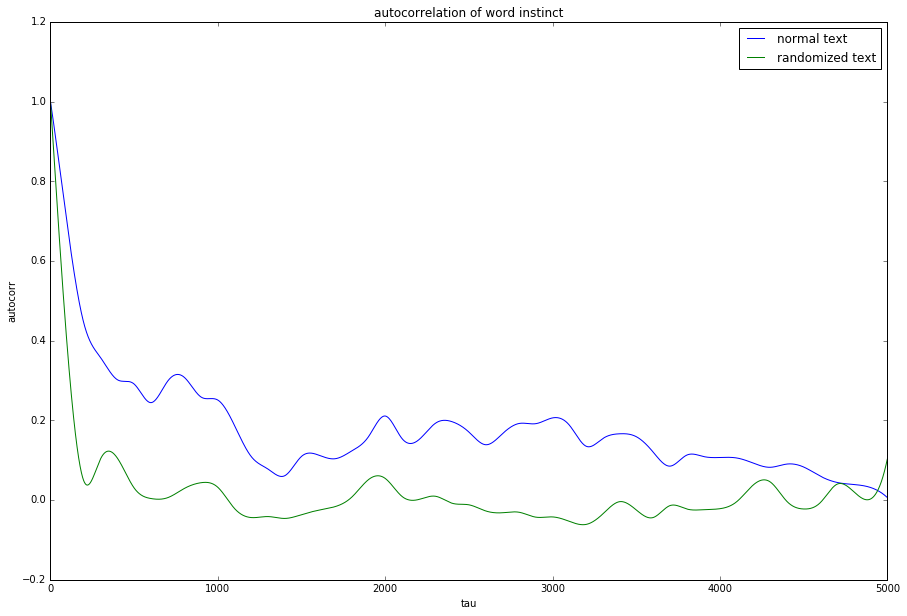

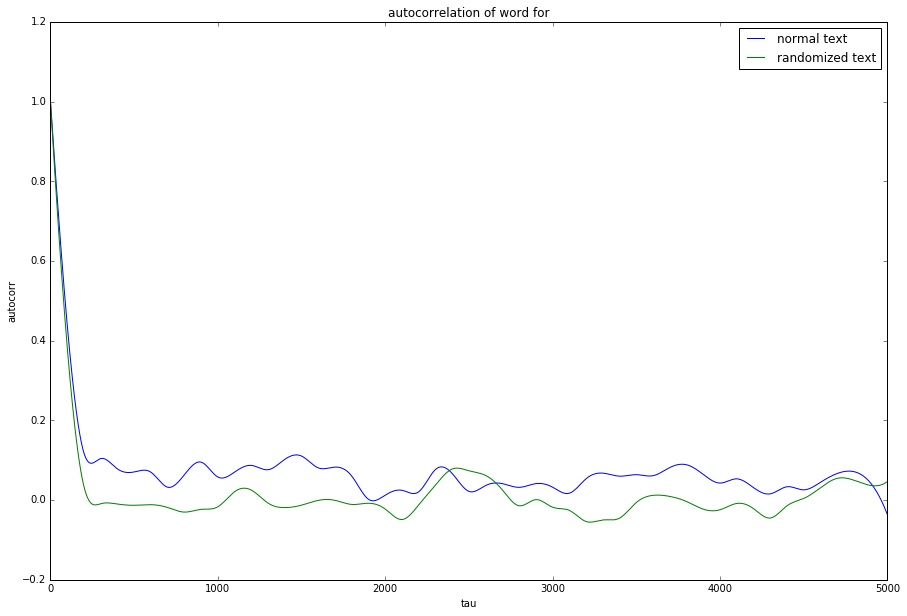

In [207]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

for word in ['instinct', 'for']:
    
    plt.figure(figsize=(15,10))
    
    x = tau_array
    y = autocorr_by_word[word]
    tck = interpolate.splrep(x, y, s=0)
    xnew = np.arange(0, 5000, 1)
    ynew = interpolate.splev(xnew, tck, der=0)
    plt.plot(xnew, ynew, label='normal text')

    x = tau_array
    y = autocorr_by_word_random[word]
    tck = interpolate.splrep(x, y, s=0)
    xnew = np.arange(0, 5000, 1)
    ynew = interpolate.splev(xnew, tck, der=0)
    plt.plot(xnew, ynew, label='randomized text')
    
    plt.title('autocorrelation of word ' + word)
    plt.xlabel('tau')
    plt.ylabel('autocorr')
    plt.legend(loc='best');
    plt.show()

Para analizar los resultados de la autocorrelación graficamos los valores obtenidos para las palabras en el texto normal vs en el texto randomizado. Se puede ver en la gráfica de la palabra 'for', cómo esta se asemeja mucho a la curva obtenida para el texto randomizado, a diferencia de los valores obtenidos para 'instinct'. Esto se debe a que 'for' es una preposición que se usa comúnmente en el idioma inglés. En cambio, 'instinct', es una palabra con mucho significado en el libro, y hay secciones específicas que tratan del tema.

#### 3. Entropía de las palabras

Para calcular la entropía se implementó la fórmula (3) del paper, y seleccionamos 100 palabras con frecuencias repartidas entre las distintas frecuencias de palabras en el texto. Para ello primero las ordenamos de mayor a menor frecuencia usando DistFreq de nltk.

Calculamos la entropía con el texto ordenado, y con el texto randomizado, y graficamos los resultados obtenidos en cada uno en un gráfico de puntos.

In [18]:
from __future__ import division

def cuantas_apariciones_en_zona(zona, palabra):
    resultado = 0
    for z in zona : 
        if z == palabra : 
            resultado = resultado + 1
    return resultado

def entropia(tokens, palabras, cant_partes = None):

    if cant_partes is None:
        cant_partes = 64

    tamanio_partes = int(len(tokens) / cant_partes)
    capitulos = []
    for i in range(0, cant_partes):
        capitulos.append(tokens[i * tamanio_partes : i * tamanio_partes + tamanio_partes])
    
    frecuencias = []
    entropias = []

    for p in palabras : 
        n_grande = cuantas_apariciones_en_zona(tokens, p)
 
        sumatoria = 0
        for i in range(0,cant_partes):
            n_chica = cuantas_apariciones_en_zona(capitulos[i] , p)
            if not n_chica == 0 : 
                sumatoria = sumatoria + np.log2(n_chica / n_grande) * (n_chica / n_grande)

        frecuencias.append(n_grande)
        entropias.append(-1*sumatoria)

    return frecuencias , entropias

In [19]:
from nltk import FreqDist

frecuencias = FreqDist(darwinTokens)

tam_frecuencias = len(frecuencias)

frecuencias_ordenadas = frecuencias.most_common(tam_frecuencias)

palabras = []
for i in range (0, tam_frecuencias, int(tam_frecuencias / 1000)):
    palabras.append(frecuencias_ordenadas[i][0])
    if len(palabras) == 100:
        break

#### 4. Comparación de la entropía obtenida en el texto normal vs el texto random

In [20]:
frecuencias, entropias = entropia(darwinTokens, palabras)

from random import shuffle
import copy

randomTokens = copy.deepcopy(darwinTokens)
shuffle(randomTokens)

frecuencias, entropias_random = entropia(randomTokens, palabras)

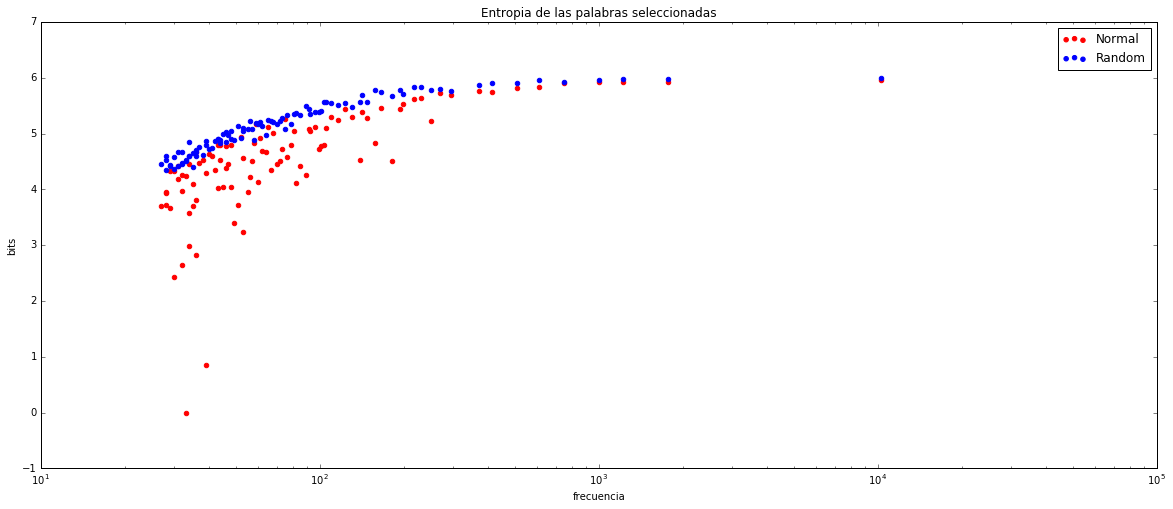

In [24]:
plt.figure(figsize=(20,8))
plt.scatter(frecuencias, entropias , label = 'Normal', color = 'r')
plt.scatter(frecuencias, entropias_random , label = 'Random', color = 'b')
plt.legend(loc='best')
ax = plt.gca()
ax.set_xscale('log')
plt.title("Entropia de las palabras seleccionadas")
plt.xlabel("frecuencia")
plt.ylabel("bits")
plt.show()

En el gráfico se puede observar que la entropía de las palabras en el texto real es, en promedio, menor que en el texto randomizado para una misma frecuencia. Esto sucede debido a que la distribución estructurada de las palabras en el texto real expresa información más compleja que las palabras ubicadas aleatoriamente en el texto mezclado. 

Además, se ve que las palabras con mayor frecuencia son poco informativas (entropía máxima). Por otro lado, la variación de la entropía para una misma frecuencia de palabras es mayor en el texto real que en el texto random. Esto se debe a que por más que un grupo de palabras aparezcan con la misma frecuencia, los patrones de ocurrencia difieren según del tipo de palabra que se trate (esto no sucede en un texto randomizado).

## Ejercicio 3: Word embeddings

### LSA Representation

Para calcular la representación LSA de las palabras utilizamos la librería gensim. Entrenamos un modelo LSI utilizando el corpus AP del ejercicio 1, y luego calculamos los vectores correspondientes al espacio LSI para cada palabra que queramos comparar.

Para calcular similaridad entre dos palabras, utilizamos el coseno entre el ángulo entre los dos vectores correspondientes a dichas palabras.

Además, estimamos el número de dimensiones para los vectores que nos diera mejores resultados, comparando la similaridad con los valores de similitud provistos por WordSim353.

In [ ]:
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models import LsiModel
from gensim.similarities import MatrixSimilarity

In [153]:
def preprocess(text):
    text = text.lower()
    doc = nltk.word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()]
    return doc

def train_lsa_model(corpus, topics):
    dictionary = corpora.Dictionary(corpus)
    corpus_gensim = [dictionary.doc2bow(doc) for doc in corpus]
    tfidf = TfidfModel(corpus_gensim)
    corpus_tfidf = tfidf[corpus_gensim]
    lsi = LsiModel(corpus_tfidf, id2word=dictionary, num_topics = topics)
    return lsi, dictionary

def convert_to_lsi_space(lsiModel, dictionary, word):
    vec_bow = dictionary.doc2bow([word])
    return lsiModel[vec_bow]

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2' """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def lsa_similarity(lsiModel, dictionary, word1, word2):
    if word1 in dictionary.values() and word2 in dictionary.values():
        v1 = convert_to_lsi_space(lsiModel, dictionary, word1)
        v2 = convert_to_lsi_space(lsiModel, dictionary, word2)
        v1 = list(map(lambda x: x[1], v1))
        v2 = list(map(lambda x: x[1], v2))
        return math.cos(angle_between(v1, v2)) * 5 + 5
    else:
        return -1

#### Armado del corpus AP

In [7]:
lsa_corpus = []

for docno, text in docs.items():
    lsa_corpus.append(preprocess(text))

#### Estimación de la dimensionalidad de los vectores

In [154]:
def estimate_best_num_topics(lsa_corpus):
    
    best_num_topics = 0
    best_fitness = 100000
    fitness_array = []

    for topics in range(0, 510, 10):
        if topics == 0:
            continue
        
        fitness = 0
        lsiModel, dictionary = train_lsa_model(lsa_corpus, topics)

        for line in open("wordsim353/combined.csv"):
            vector = line.split(",")
            primera_palabra = vector[0]
            segunda_palabra = vector[1]
            puntaje = vector[2]

            sim_lsa = lsa_similarity(lsiModel, dictionary, primera_palabra, segunda_palabra)
            
            if (sim_lsa != -1):
                fitness += abs(float(puntaje) - sim_lsa)
        
        fitness_array.append(fitness)

        if fitness < best_fitness:
            best_fitness = fitness
            best_num_topics = topics
    
    return best_num_topics, fitness_array

In [ ]:
num_topics_chosen, fitness_array = estimate_best_num_topics(lsa_corpus)

In [158]:
num_topics_chosen

70

#### Entrenamiento del modelo

In [159]:
lsiModel, dictionary = train_lsa_model(lsa_corpus, num_topics_chosen)

### Word2Vec Representation

Para la representación de Word2Vec utilizamos nuevamente una librería de gensim.models, entrenando el modelo con el mismo corpus que en el caso anterior (corpus AP del ejercicio 1).

In [160]:
word2vec_corpus = lsa_corpus

In [161]:
from gensim.models import word2vec
import logging

def word2vec_similarity(primera_palabra, segunda_palabra, word_vectors):
    try:
        return word_vectors.similarity(primera_palabra, segunda_palabra) * 10        
    except KeyError:
        return -1

#### Estimación de la dimensionalidad de los vectores

In [162]:
def estimate_word2vec_size():
    best_num_topics = 0
    best_fitness = 100000
    fitness_array = []

    for topics in range(0, 510, 10):
        if topics == 0:
            continue
        
        fitness = 0
        model = word2vec.Word2Vec(word2vec_corpus, size=topics)
        word_vectors = model.wv

        for line in open("wordsim353/combined.csv"):
            vector = line.split(",")
            primera_palabra = vector[0]
            segunda_palabra = vector[1]
            puntaje = vector[2]
            
            sim_word2vec = word2vec_similarity(primera_palabra, segunda_palabra, word_vectors)
            
            if (sim_word2vec != -1):
                fitness += abs(float(puntaje) - sim_word2vec)
        
        fitness_array.append(fitness)

        print(topics, fitness)

        if fitness < best_fitness:
            best_fitness = fitness
            best_num_topics = topics
    
    return best_num_topics, fitness_array

In [163]:
size_chosen, fitness_array = estimate_word2vec_size()

(10, 590.65636366929994)
(20, 556.65796757883686)
(30, 554.26979971440608)
(40, 546.79801534738169)
(50, 553.0495019082374)
(60, 556.52811818713747)
(70, 557.69458765095658)
(80, 565.77093929712146)
(90, 568.51550358166321)
(100, 566.14547326232037)
(110, 567.36177006384833)
(120, 570.41996035508896)
(130, 566.70603740405488)
(140, 563.91992358470065)
(150, 559.26124750469057)
(160, 563.98722345851763)
(170, 571.78001903018117)
(180, 565.71262114187186)
(190, 570.93932398406605)
(200, 570.25629907457471)
(210, 581.74719441812965)
(220, 583.86760699508113)
(230, 585.16950307241109)
(240, 574.97863506648639)
(250, 585.93429007683358)
(260, 587.51418804375248)
(270, 584.55280630950483)
(280, 586.53422336939536)
(290, 581.25672785226402)
(300, 577.32012109571463)
(310, 586.90835390996676)
(320, 588.26141457628898)
(330, 581.97273462568057)
(340, 580.75371949524549)
(350, 578.11966242970129)
(360, 577.31202206984744)
(370, 569.11376609434762)
(380, 593.82047280713527)
(390, 587.983560036472

#### Entrenamiento del modelo

In [164]:
size_chosen

40

In [166]:
model = word2vec.Word2Vec(word2vec_corpus, size=size_chosen)
word_vectors = model.wv

### Comparación usando WordSim353

Para realizar la comparación, computamos la similaridad dada por el modelo LSA y el de Word2Vec y la comparamos con el valor de similaridad dado por uno de los archivos descargados de WordSim353.

Para compararlo, calculamos en cada iteración el modelo que arroja menor error (diferencia absoluta entre similaridad del modelo y similaridad de WordSim353). Luego se muestran en una tabla las palabras comparadas (sólo comparamos aquellas que se encontraban en el corpus de entrenamiento) junto con los resultados obtenidos con cada modelo.

In [167]:
words1 = []
words2 = []
wordsims = []

lsa_sims = []
w2v_sims = []
better_model = []

with open("wordsim353/combined.csv") as fp:
    line = fp.readline()
    while line:
        line = fp.readline()
        vector = line.split(",")
        
        if len(vector) != 3:
            continue

        primera_palabra = vector[0]
        segunda_palabra = vector[1]
        puntaje = float(vector[2])

        sim_word2vec = word2vec_similarity(primera_palabra, segunda_palabra, word_vectors)
        sim_lsa = lsa_similarity(lsiModel, dictionary, primera_palabra, segunda_palabra)

        if not (sim_word2vec == -1 or sim_lsa == -1):

            words1.append(primera_palabra)
            words2.append(segunda_palabra)
            lsa_sims.append(format(sim_lsa, '.2f'))
            w2v_sims.append(format(sim_word2vec, '.2f'))
            wordsims.append(format(puntaje, '.2f'))

            w2v_fitness = abs(puntaje - sim_word2vec)
            lsa_fitness = abs(puntaje - sim_lsa)

            if w2v_fitness < lsa_fitness:
                better_model.append('W2V')
            elif w2v_fitness > lsa_fitness:
                better_model.append('LSA')
            else:
                better_model.append('-')

#### Resultados

En la siguiente tabla se pueden ver la similaridad obtenida por WordSim353, con el modelo LSA y con el modelo de Word2Vec, junto con el modelo que mejor se acercó al resultado de WordSim353.

In [168]:
df = pd.DataFrame(data= OrderedDict((
    ('Word 1', words1), ('Word 2', words2), ('WordSim353', wordsims),
    ('LSA', lsa_sims), ('Word2Vec', w2v_sims), ('Better Model', better_model))) )

df

,Word 1,Word 2,WordSim353,LSA,Word2Vec,Better Model
0,love,sex,6.77,5.51,8.39,LSA
1,tiger,cat,7.35,4.45,9.10,W2V
2,tiger,tiger,10.00,10.00,10.00,-
3,book,paper,7.46,5.45,8.48,W2V
4,plane,car,5.77,4.98,8.32,LSA
5,train,car,6.31,6.32,8.49,LSA
6,telephone,communication,7.50,5.21,3.65,LSA
7,television,radio,6.77,6.63,9.35,LSA
8,media,radio,7.42,6.24,8.90,LSA
9,drug,abuse,6.85,7.30,7.71,LSA


#### Cantidad de pares en los que LSA funcionó mejor

In [169]:
sum(map(lambda m: m == 'LSA', better_model))

159

In [170]:
def mean_error(wordsims, model_sims):
    error = 0
    for i in range(0, len(wordsims)):
        error += abs(float(wordsims[i]) - float(model_sims[i]))
    return error / len(wordsims)

#### Error medio obtenido por LSA similarity

In [171]:
mean_error(wordsims, lsa_sims)

1.562272727272728

#### Cantidad de pares en los que Word2Vec funcionó mejor

In [172]:
sum(map(lambda m: m == 'W2V', better_model))

82

#### Error medio obtenido por Word2Vec similarity

In [173]:
mean_error(wordsims, w2v_sims)

2.2759090909090904

Para la comparación con WordSim353 se obtuvieron mejores resultados utilizando la conversión que usa LSA. Aproximadamente 2/3 de los pares dieron más cercanos a la similaridad de WordSim con LSA, y el error medio obtenido también fue menor, de aproximadamente 1.6 sobre una categorización de 0 a 10 de similaridad.

Notar que todos los valores de similaridad de encuentran entre 0 y 10 para poder comparar con los valores provistos por WordSim353.

### Comparación usando WordNet Similarity

Análogamente al ejercicio anterior, compararemos los resultados obtenidos con cada modelo, pero esta vez con dos de las medidas presentadas en el módulo WordNet de nltk para similaridad:
1. Path Similarity
2. Wu-Palmer Similarity


#### Resultados

En la siguiente tabla se pueden ver la similaridad obtenida por las medidas de WordNet, con el modelo LSA y con el modelo de Word2Vec, junto con el modelo que mejor se acercó, en promedio, a las medidas de similaridad de WordNet.

In [186]:
wnet1_sims = []
wnet2_sims = []

wnet_words1 = []
wnet_words2 = []
wnet_lsa_sims = []
wnet_w2v_sims = []
wnet_better_model = []

for i in range(0, len(wordsims)):
    
    try:
        word1 = wn.synset(words1[i] + '.n.01')
        word2 = wn.synset(words2[i] + '.n.01')
    except:
        continue
    
    wnet_words1.append(words1[i])
    wnet_words2.append(words2[i])
    wnet_lsa_sims.append(lsa_sims[i])
    wnet_w2v_sims.append(w2v_sims[i])
    
    wnet1_sim = wn.path_similarity(word1, word2) * 10
    wnet2_sim = wn.wup_similarity(word1, word2) * 10 # Wu-Palmer Similarity
    wnet1_sims.append(format(wnet1_sim, '.2f'))
    wnet2_sims.append(format(wnet2_sim, '.2f'))

    w2v_error = abs(wnet1_sim - float(w2v_sims[i])) + abs(wnet2_sim - float(w2v_sims[i]))
    lsa_error = abs(wnet1_sim - float(lsa_sims[i])) + abs(wnet2_sim - float(lsa_sims[i]))
    
    if w2v_error < lsa_error:
        wnet_better_model.append('W2V')
    elif w2v_error > lsa_error:
        wnet_better_model.append('LSA')
    else:
        wnet_better_model.append('-')

df = pd.DataFrame(data= OrderedDict((
    ('Word 1', wnet_words1), ('Word 2', wnet_words2), ('Path Sim.', wnet1_sims), ('Wu-Palmer Sim.', wnet2_sims),
    ('LSA', wnet_lsa_sims), ('Word2Vec', wnet_w2v_sims), ('Better Model', wnet_better_model))) )

df

,Word 1,Word 2,Path Sim.,Wu-Palmer Sim.,LSA,Word2Vec,Better Model
0,love,sex,0.83,1.54,5.51,8.39,LSA
1,tiger,cat,0.91,5.45,4.45,9.10,LSA
2,tiger,tiger,10.00,7.50,10.00,10.00,-
3,book,paper,0.77,2.50,5.45,8.48,LSA
4,plane,car,1.11,6.67,4.98,8.32,LSA
5,train,car,1.25,6.67,6.32,8.49,LSA
6,telephone,communication,0.71,1.33,5.21,3.65,W2V
7,television,radio,3.33,9.00,6.63,9.35,LSA
8,drug,abuse,0.77,1.43,7.30,7.71,LSA
9,bread,butter,2.50,7.50,6.24,9.09,LSA


#### Cantidad de pares en los que LSA funcionó mejor

In [187]:
sum(map(lambda m: m == 'LSA', wnet_better_model))

163

In [176]:
def wnet_mean_error(wnet1_sims, wnet2_sims, model_sims):
    error = 0
    for i in range(0, len(wnet1_sims)):
        error += abs(float(wnet1_sims[i]) - float(model_sims[i]))
        error += abs(float(wnet2_sims[i]) - float(model_sims[i]))
    return error / len(wnet1_sims) / 2

#### Error medio obtenido por LSA similarity

In [177]:
wnet_mean_error(wnet1_sims, wnet2_sims, wnet_lsa_sims)

3.7408510638297874

#### Cantidad de pares en los que W2V funcionó mejor

In [178]:
sum(map(lambda m: m == 'W2V', wnet_better_model))

56

#### Error medio obtenido por W2V similarity

In [179]:
wnet_mean_error(wnet1_sims, wnet2_sims, wnet_w2v_sims)

4.91276595744681

En este caso, nuevamente los valores de similaridad obtenidos por LSA se asemejaron más a las medidas de WordNet, con una amplia diferencia de pares en los que funcionó mejor comparado con Word2Vec. El error medio, sin embargo, fue mayor que con los valores de similaridad de WordSim353 para ambos modelos.